# AttriPredict - Attrition EDA Storyboard

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from IPython.display import display

sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 12,
    "axes.labelsize": 11,
})

TARGET_COL = "Attrition"
DROP_COLS = ["Over18", "StandardHours", "EmployeeNumber"]
NOMINAL_FEATURES = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]
ORDINAL_FEATURES = [
    "Education",
    "EnvironmentSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "JobSatisfaction",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]
SATISFACTION_LABELS = {
    1: "1 · 紧急干预",
    2: "2 · 值得关注",
    3: "3 · 可接受",
    4: "4 · 体验佳",
}

DATA_DIR = Path("../../data")
pd.options.display.max_columns = 40
pd.options.display.float_format = "{:.2f}".format
rng = np.random.default_rng(42)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 数据底稿与抽样口径

- 1100 名员工，原始 31 列，移除 `Over18`、`StandardHours`、`EmployeeNumber` 后剩 28 个特征 + 1 个标签。
- 目标列 `Attrition` 在源数据已编码为 0/1，这里再创建 `AttritionLabel`，让可视化直接区分“留任/流失”。
- 抽样口径与 01 / 02 Notebook 完全一致，确保 EDA → 特征工程 → 生产是一套口径。


In [14]:
df_raw = pd.read_csv(DATA_DIR / "train.csv")
df = df_raw.drop(columns=DROP_COLS).copy()
df[TARGET_COL] = df[TARGET_COL].astype(int)
df["AttritionLabel"] = df[TARGET_COL].map({0: "留任", 1: "流失"})

numeric_features = [
    col for col in df.select_dtypes(include=["int64", "float64"]).columns
    if col not in {TARGET_COL}
]
categorical_features = [
    col for col in df.select_dtypes(include=["object"]).columns
    if col not in DROP_COLS
]

overview = pd.DataFrame(
    {
        "指标": ["样本量", "可用字段数", "目标流失率"],
        "取值": [len(df), len(df.columns) - 1, df[TARGET_COL].mean()],
    }
)

print("数据口径概览：")
display(overview)
print("—— 抽样预览 ——")
display(df.head(3))

数据口径概览：


,指标,取值
0,样本量,1100.00
1,可用字段数,28.00
2,目标流失率,0.16


—— 抽样预览 ——


,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionLabel
0,0,37,Travel_Rarely,Research & Development,1,4,Life Sciences,1,Male,2,2,Manufacturing Director,3,Divorced,5993,1,No,18,3,3,1,7,2,4,7,5,0,7,留任
1,0,54,Travel_Frequently,Research & Development,1,4,Life Sciences,4,Female,3,3,Manufacturing Director,3,Divorced,10502,7,No,17,3,1,1,33,2,1,5,4,1,4,留任
2,1,34,Travel_Frequently,Research & Development,7,3,Life Sciences,1,Male,1,2,Laboratory Technician,3,Single,6074,1,Yes,24,4,4,0,9,3,3,9,7,0,6,流失


## 数据健康：缺失、常量与重复

- 先确认数据没有“脏点”：所有列无缺失、极少数列接近常量，也不存在重复员工。
- 这些检查让我们可以自信地使用 `StandardScaler`、`log1p`、One-Hot，并把类型统计直接带到 01/02 的特征脚本里。


In [15]:
health_df = pd.DataFrame(
    {
        "字段": df.columns,
        "类型": df.dtypes.astype(str).values,
        "唯一值": df.nunique().values,
        "缺失值": df.isna().sum().values,
    }
)
duplicate_rows = df.duplicated().sum()

print(f"是否存在重复员工记录: {'是' if duplicate_rows else '否'} (数量={duplicate_rows})")
display(health_df.sort_values("缺失值", ascending=False).head(12))

是否存在重复员工记录: 否 (数量=0)


,字段,类型,唯一值,缺失值
0,Attrition,int32,2,0
15,NumCompaniesWorked,int64,10,0
27,YearsWithCurrManager,int64,18,0
26,YearsSinceLastPromotion,int64,16,0
25,YearsInCurrentRole,int64,19,0
24,YearsAtCompany,int64,35,0
23,WorkLifeBalance,int64,4,0
22,TrainingTimesLastYear,int64,7,0
21,TotalWorkingYears,int64,40,0
20,StockOptionLevel,int64,4,0


## 目标标签：流失率与类别不平衡

- 整体流失率约 16%，明显偏向负类，意味着“准确率”不是可靠指标，必须统一看 AUC 和 PR-AUC。
- 类别不平衡提示我们要尝试 SMOTE、ADASYN、BorderlineSMOTE、SMOTEENN、SMOTETomek 等采样方式，并且在 01/02 中坚持分层交叉验证。


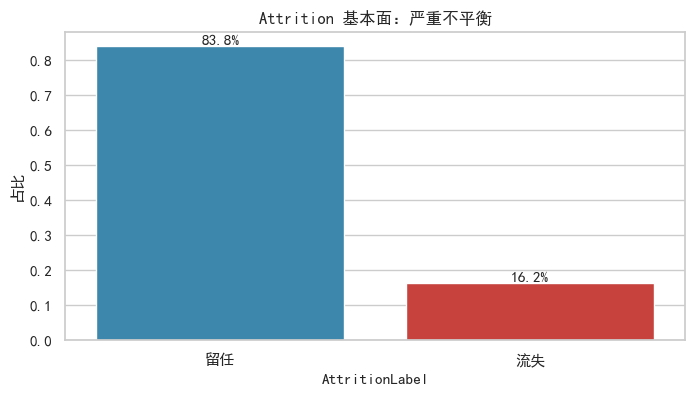

,AttritionLabel,count,rate
0,留任,922,0.84
1,流失,178,0.16


In [ ]:
target_summary = (
    df[TARGET_COL]
    .value_counts()
    .rename_axis("Attrition")
    .reset_index(name="count")
    .sort_values("Attrition")
)
target_summary["rate"] = target_summary["count"] / len(df)
target_summary["AttritionLabel"] = target_summary["Attrition"].map({0: "留任", 1: "流失"})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=target_summary,
    x="AttritionLabel",
    y="rate",
    hue="AttritionLabel",
    palette=["#2b8cbe", "#de2d26"],
    legend=False,
    ax=ax,
)

ax.set_title("Attrition 基本面：严重不平衡")
ax.set_ylabel("占比")
for p, rate in zip(ax.patches, target_summary["rate"]):
    ax.annotate(f"{rate:.1%}", (p.get_x() + p.get_width() / 2, rate), ha="center", va="bottom", fontsize=11) # type: ignore
plt.show()

display(target_summary[["AttritionLabel", "count", "rate"]])

## 人口属性：年龄 & 家庭结构

- 年龄分布接近正态，但 30-40 岁段的流失比例明显抬升，于是我们在 02 Pipeline 里保留 `Age × MonthlyIncome`、`Age × JobLevel` 这类交互。
- 婚姻状态上离异/单身人群更易流失，提示要把 `MaritalStatus` 与满意度或 `WorkLifeBalance` 联动建模，支撑后续特征工程。


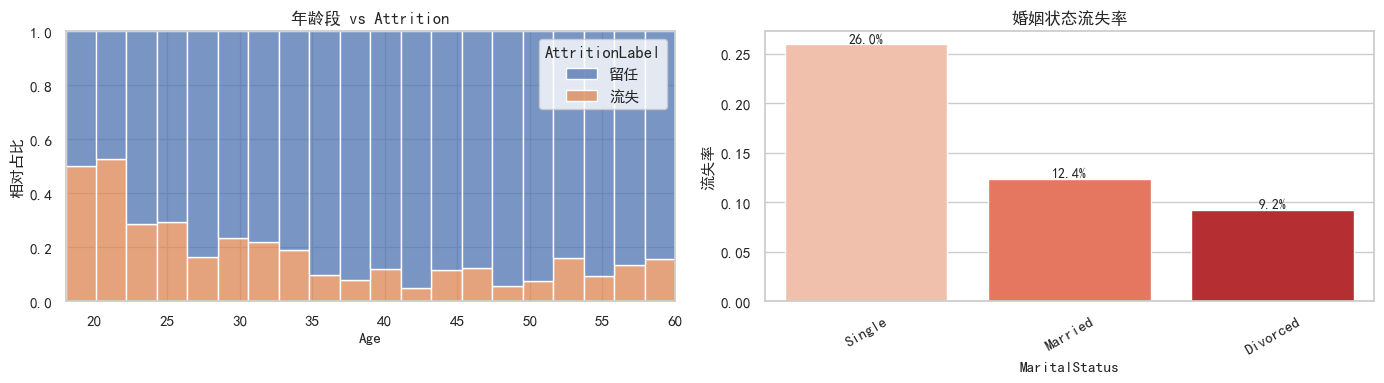

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(
    data=df,
    x="Age",
    hue="AttritionLabel",
    bins=20,
    ax=axes[0],
    stat="density",
    multiple="fill",
)
axes[0].set_title("年龄段 vs Attrition")
axes[0].set_ylabel("相对占比")

marital_summary = (
    df.groupby("MaritalStatus")[TARGET_COL]
    .agg(["mean", "count"])
    .rename(columns={"mean": "attrition_rate", "count": "headcount"})
    .reset_index()
    .sort_values("attrition_rate", ascending=False)
)

sns.barplot(
    data=marital_summary,
    x="MaritalStatus",
    y="attrition_rate",
    hue="MaritalStatus",
    palette="Reds",
    legend=False,
    ax=axes[1],
)
axes[1].set_title("婚姻状态流失率")
axes[1].set_ylabel("流失率")
axes[1].tick_params(axis="x", rotation=30)
for p, rate in zip(axes[1].patches, marital_summary["attrition_rate"]):
    axes[1].annotate(f"{rate:.1%}", (p.get_x() + p.get_width() / 2, rate), ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

## 出差强度 & 加班：工作模式失衡

- 频繁差旅叠加加班几乎覆盖半数流失样本，是 SMOTE 要重点补齐的稀疏组合。
- 热力图显示 Travel_Frequently 中加班的放大效应，01 的穷举矩阵也因此单独给这些组合创建交互项及采样权重。


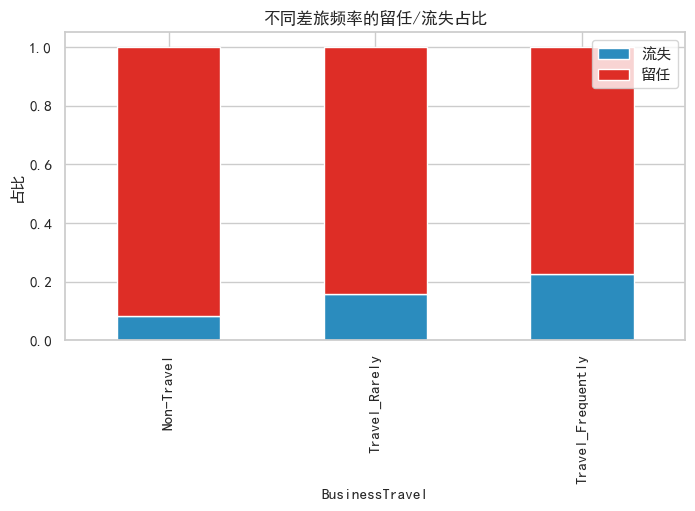

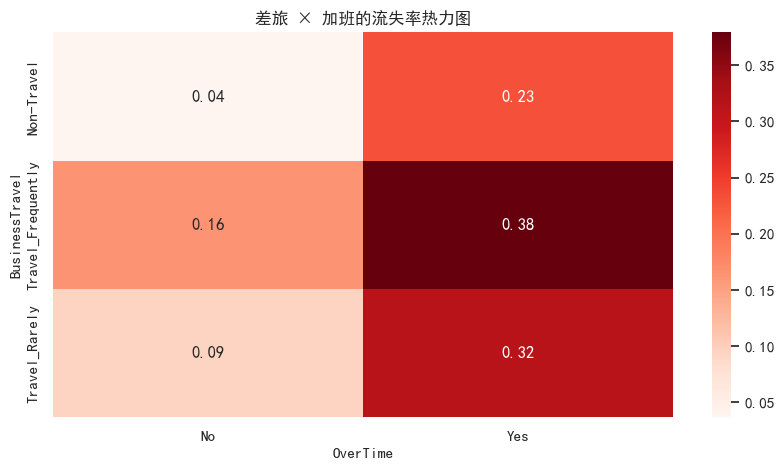

In [18]:
travel_crosstab = (
    pd.crosstab(df["BusinessTravel"], df["AttritionLabel"], normalize="index")
    .reindex(["Non-Travel", "Travel_Rarely", "Travel_Frequently"])
)
travel_crosstab.plot(kind="bar", stacked=True, color=["#2b8cbe", "#de2d26"], figsize=(8, 4))
plt.title("不同差旅频率的留任/流失占比")
plt.ylabel("占比")
plt.legend(loc="upper right")
plt.show()

overtime_summary = (
    df.groupby(["OverTime", "BusinessTravel"])[TARGET_COL]
    .mean()
    .reset_index()
    .pivot(index="BusinessTravel", columns="OverTime", values=TARGET_COL)
)

sns.heatmap(overtime_summary, annot=True, fmt=".2f", cmap="Reds")
plt.title("差旅 × 加班的流失率热力图")
plt.ylabel("BusinessTravel")
plt.show()


## 部门 & 岗位：业务线的异质性

- 部门之间的流失率差异不算极端，但同一部门内不同 `JobRole` 的分布非常不均，需要在 01 中做 One-Hot / Target Encoding 对照。
- 这一组图先展示部门整体，再 drill down 到岗位，让“岗位画像”成为人口画像路线里的第一条支线。


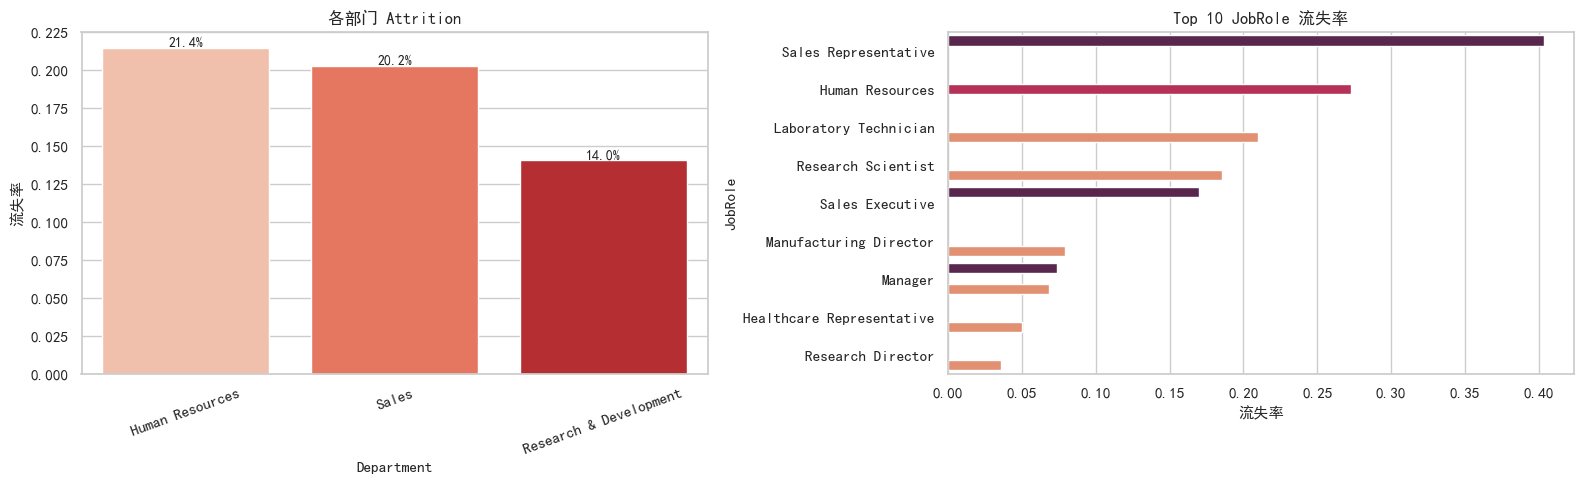

In [19]:

dept_summary = (
    df.groupby("Department")[TARGET_COL]
    .agg(["mean", "count"])
    .rename(columns={"mean": "attrition_rate", "count": "headcount"})
    .reset_index()
    .sort_values("attrition_rate", ascending=False)
)

jobrole_summary = (
    df.groupby(["Department", "JobRole"])[TARGET_COL]
    .agg(["mean", "count"])
    .rename(columns={"mean": "attrition_rate", "count": "headcount"})
    .reset_index()
    .sort_values("attrition_rate", ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(data=dept_summary, x="Department", y="attrition_rate", hue="Department", palette="Reds", legend=False, ax=axes[0])
axes[0].set_title("各部门 Attrition")
axes[0].set_ylabel("流失率")
axes[0].tick_params(axis="x", rotation=20)
for p, rate in zip(axes[0].patches, dept_summary["attrition_rate"]):
    axes[0].annotate(f"{rate:.1%}", (p.get_x() + p.get_width() / 2, rate), ha="center", va="bottom", fontsize=10)

sns.barplot(
    data=jobrole_summary.head(10),
    y="JobRole",
    x="attrition_rate",
    hue="Department",
    palette="rocket",
    legend=False,
    ax=axes[1],
)
axes[1].set_title("Top 10 JobRole 流失率")
axes[1].set_xlabel("流失率")
plt.tight_layout()
plt.show()


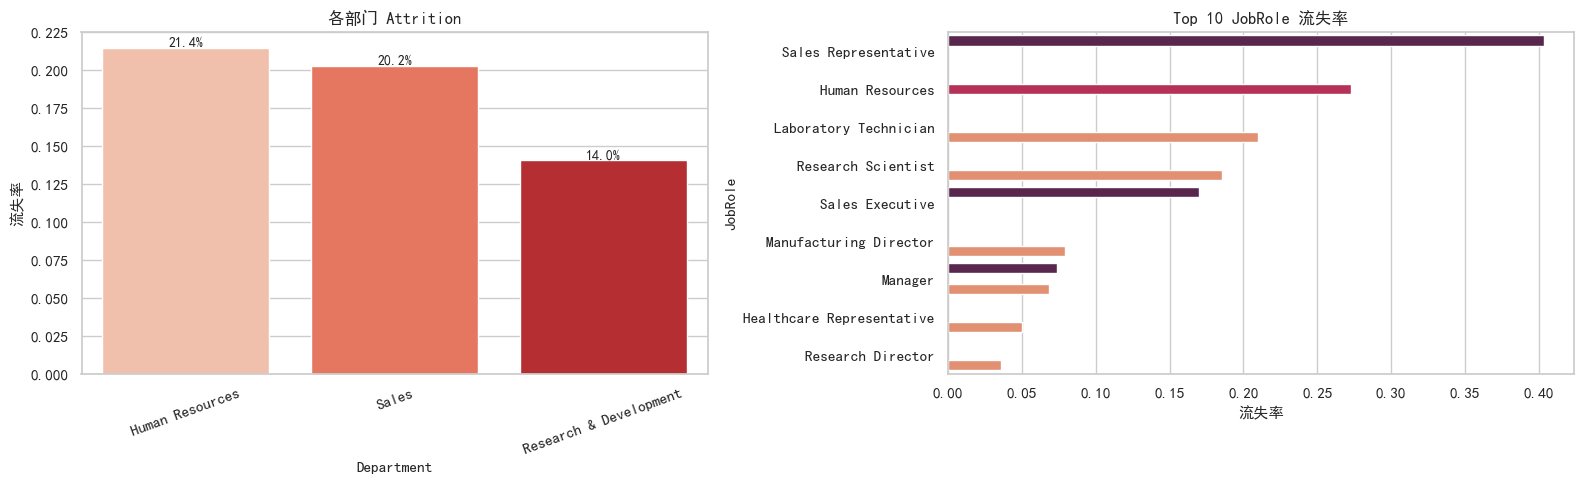

In [20]:

dept_summary = (
    df.groupby("Department")[TARGET_COL]
    .agg(["mean", "count"])
    .rename(columns={"mean": "attrition_rate", "count": "headcount"})
    .reset_index()
    .sort_values("attrition_rate", ascending=False)
)

jobrole_summary = (
    df.groupby(["Department", "JobRole"])[TARGET_COL]
    .agg(["mean", "count"])
    .rename(columns={"mean": "attrition_rate", "count": "headcount"})
    .reset_index()
    .sort_values("attrition_rate", ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(data=dept_summary, x="Department", y="attrition_rate", hue="Department", palette="Reds", legend=False, ax=axes[0])
axes[0].set_title("各部门 Attrition")
axes[0].set_ylabel("流失率")
axes[0].tick_params(axis="x", rotation=20)
for p, rate in zip(axes[0].patches, dept_summary["attrition_rate"]):
    axes[0].annotate(f"{rate:.1%}", (p.get_x() + p.get_width() / 2, rate), ha="center", va="bottom", fontsize=10)

sns.barplot(
    data=jobrole_summary.head(10),
    y="JobRole",
    x="attrition_rate",
    hue="Department",
    palette="rocket",
    legend=False,
    ax=axes[1],
)
axes[1].set_title("Top 10 JobRole 流失率")
axes[1].set_xlabel("流失率")
plt.tight_layout()
plt.show()


## 职业生命周期：任职年限、晋升与岗位轮换

- Attrition 在 0-3 年与 9-12 年各出现一次波峰，对应 HR 所说的“适应期”和“平台期”，因此 01 中把 `YearsAtCompany` 离散化后喂给多模型对比。
- `YearsSinceLastPromotion` × `YearsInCurrentRole` 的热力图揭示“晋升停滞”群体，是 02 Pipeline 里构造“晋升停滞指数”“Manager 接触年限”等高级特征的直接依据。


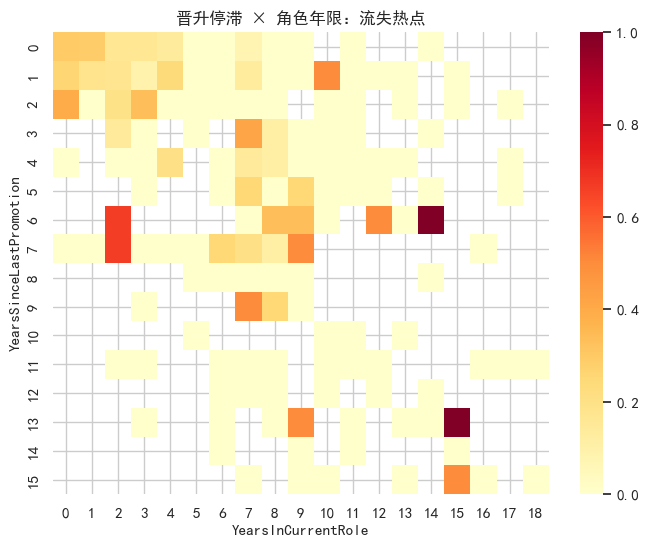

In [21]:
tenure_summary = (
    df.groupby("YearsAtCompany")[TARGET_COL]
    .agg(["mean", "count"])
    .rename(columns={"mean": "attrition_rate", "count": "headcount"})
    .reset_index()
)

fig_tenure = px.line(
    tenure_summary,
    x="YearsAtCompany",
    y="attrition_rate",
    markers=True,
    hover_data={"headcount": True},
    title="YearsAtCompany vs Attrition Rate",
)
fig_tenure.update_layout(yaxis_tickformat=".0%")
fig_tenure.show()

promo_pivot = (
    df.groupby(["YearsSinceLastPromotion", "YearsInCurrentRole"])[TARGET_COL]
    .mean()
    .reset_index()
    .pivot(index="YearsSinceLastPromotion", columns="YearsInCurrentRole", values=TARGET_COL)
)

plt.figure(figsize=(8, 6))
sns.heatmap(promo_pivot, cmap="YlOrRd", annot=False)
plt.title("晋升停滞 × 角色年限：流失热点")
plt.xlabel("YearsInCurrentRole")
plt.ylabel("YearsSinceLastPromotion")
plt.show()

## 满意度 & 敬业度矩阵

- 五个主观评分都只有 1-4 分，最适合 One-Hot 之后再接 `StandardScaler`，必要时辅以 `log1p` 缓和偏斜。
- 热力图显示当任意一项跌到 1 分时流失率翻倍，因此 02 的两个场景都选择完整保留这些列，并在 01 的 `SelectKBest` 阶段重点评估它们的重要性。


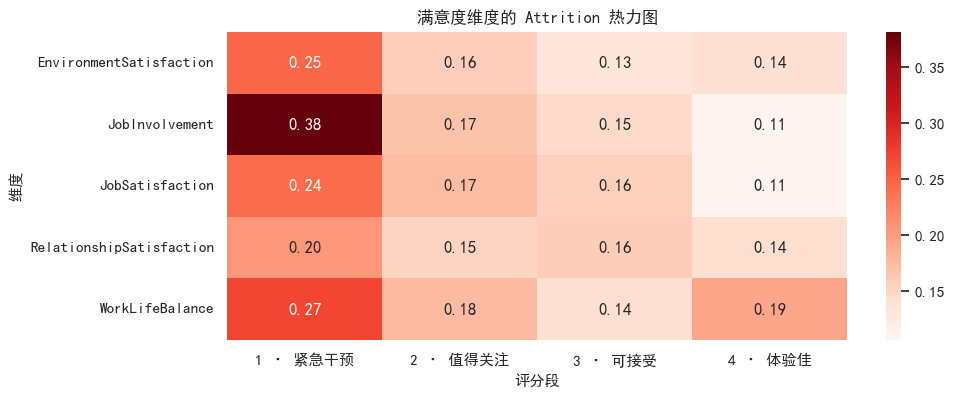

In [22]:
sat_cols = [
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "RelationshipSatisfaction",
    "JobInvolvement",
    "WorkLifeBalance",
]
sat_long = df.melt(id_vars=[TARGET_COL], value_vars=sat_cols, var_name="metric", value_name="score")
sat_long["score_label"] = sat_long["score"].map(SATISFACTION_LABELS)

sat_heatmap = (
    sat_long.groupby(["metric", "score_label"])[TARGET_COL]
    .mean()
    .reset_index()
    .pivot(index="metric", columns="score_label", values=TARGET_COL)
    .loc[:, sorted(SATISFACTION_LABELS.values())]
)

plt.figure(figsize=(10, 4))
sns.heatmap(sat_heatmap, annot=True, fmt=".2f", cmap="Reds")
plt.title("满意度维度的 Attrition 热力图")
plt.xlabel("评分段")
plt.ylabel("维度")
plt.show()

## 薪酬、加班与年龄：补偿是否匹配付出？

- `MonthlyIncome` 呈长尾分布，是我们引入 `log1p` + 标准化的直接原因；箱线图也验证月薪 <5k 且长期加班的人群高度重叠。
- 散点图结合 `JobLevel` 的点径，让“年龄高但收入低”的异常点一目了然，可在 01 穷举和 02 FeaturePipeline 中转化为交互项或异常评分。


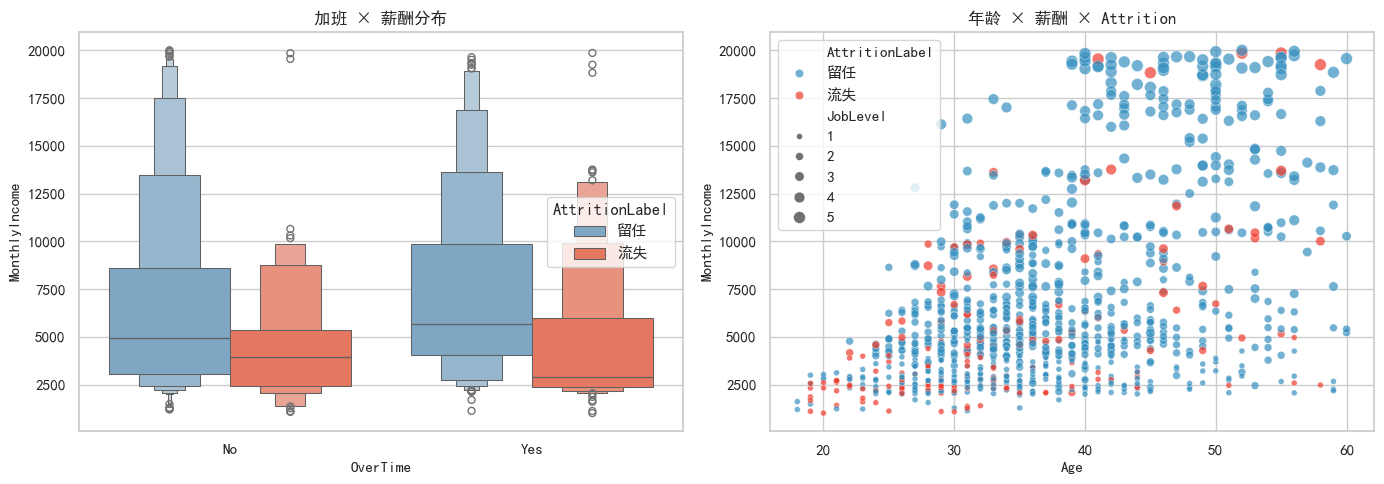

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxenplot(
    data=df,
    x="OverTime",
    y="MonthlyIncome",
    hue="AttritionLabel",
    palette=["#74a9cf", "#fb6a4a"],
    ax=axes[0],
)
axes[0].set_title("加班 × 薪酬分布")
axes[0].set_ylabel("MonthlyIncome")

sns.scatterplot(
    data=df,
    x="Age",
    y="MonthlyIncome",
    hue="AttritionLabel",
    size="JobLevel",
    palette={"留任": "#3690c0", "流失": "#ef3b2c"},
    alpha=0.7,
    ax=axes[1],
)
axes[1].set_title("年龄 × 薪酬 × Attrition")
axes[1].set_ylabel("MonthlyIncome")

plt.tight_layout()
plt.show()

## 相关性 & 分类 Lift：把洞察映射到特征工程

- 数值相关矩阵帮助我们挑出可以做多项式/交互的配对，例如 `YearsAtCompany × YearsWithCurrManager`。
- Top-Lift 排行说明 `OverTime = Yes`、`JobRole = Sales Representative` 等类别会显著抬高流失率，于是 01 / 02 都保留这些 One-Hot，并视需要做目标编码或加权处理。


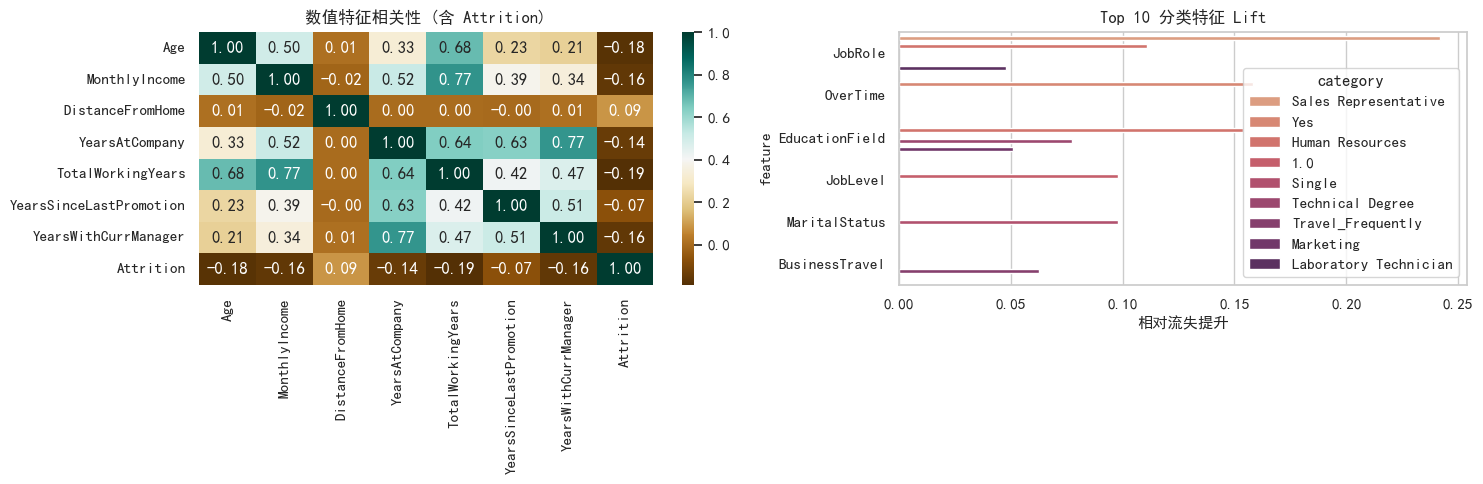

,feature,category,lift,headcount
5,JobRole,Sales Representative,0.24,57
3,OverTime,Yes,0.16,306
11,EducationField,Human Resources,0.15,19
6,JobRole,Human Resources,0.11,33
14,JobLevel,1.00,0.10,412
8,MaritalStatus,Single,0.10,362
12,EducationField,Technical Degree,0.08,92
0,BusinessTravel,Travel_Frequently,0.06,205
13,EducationField,Marketing,0.05,127
7,JobRole,Laboratory Technician,0.05,205


In [24]:
corr_features = [
    "Age",
    "MonthlyIncome",
    "DistanceFromHome",
    "YearsAtCompany",
    "TotalWorkingYears",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager",
]
corr_matrix = df[corr_features + [TARGET_COL]].corr()

cat_cols = ["BusinessTravel", "OverTime", "JobRole", "MaritalStatus", "EducationField", "JobLevel"]
avg_attrition = df[TARGET_COL].mean()
lift_rows = []
for col in cat_cols:
    stats = df.groupby(col)[TARGET_COL].agg(["mean", "count"]).reset_index()
    stats["lift"] = stats["mean"] - avg_attrition
    top_rows = stats.sort_values("lift", ascending=False).head(3)
    for _, row in top_rows.iterrows():
        lift_rows.append({
            "feature": col,
            "category": row[col],
            "lift": row["lift"],
            "headcount": int(row["count"]),
        })

lift_df = pd.DataFrame(lift_rows).sort_values("lift", ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="BrBG", ax=axes[0])
axes[0].set_title("数值特征相关性 (含 Attrition)")

sns.barplot(
    data=lift_df,
    y="feature",
    x="lift",
    hue="category",
    palette="flare",
    ax=axes[1],
)
axes[1].set_title("Top 10 分类特征 Lift")
axes[1].set_xlabel("相对流失提升")
plt.tight_layout()
plt.show()

display(lift_df)